In [49]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import numpy as np
import pandas as pd
import torch

from hparams import create_hparams
from model import SpeakerEncoder
from loss import SpeakerEncoderLoss
from audio import init_stft, mel_spectrogram

import os
import warnings
warnings.filterwarnings("ignore")

In [50]:
F = 70

def get_embeddings(model, data, data_dir):
    embeddings = []
    for _, row in data.iterrows():
        mel = mel_spectrogram(os.path.join(data_dir, row['audio']), stft).transpose(0, 1).unsqueeze(0) # 1xSxM
        fragments = mel.unfold(1, F, F // 2).transpose(2, 3)[0]
        embedding = model.inference(fragments, [fragments.size(0)]).squeeze(0)
        embeddings.append(embedding)
    return torch.stack(embeddings).detach()

In [51]:
def load_model(checkpoint_path):
    model = SpeakerEncoder(hparams)
    if checkpoint_path is not None: 
        model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu'))['state_dict'])
    return model

In [52]:
import IPython

def play_audio(audio, data_dir):
    return IPython.display.Audio(os.path.join(data_dir, audio), autoplay=True)

In [53]:
def get_speaker_sample(data, speaker):
    return data.loc[data['speaker'] == speaker].sample(1).iloc[0]

In [54]:
from sklearn.decomposition import PCA
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 12)})

def pca_plot(embeddings, labels, genders=None):
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings.numpy())

    for label in np.sort(np.unique(labels)):
        label_index = labels == label
        marker = None if genders is None else ('x' if genders[label] else '.')
        plt.scatter(embeddings_2d[label_index, 0], embeddings_2d[label_index, 1], label=label, marker=marker)
    plt.legend()

In [105]:
from sklearn.metrics.pairwise import linear_kernel

def embedding_stats(embeddings, N, M):
    losses = [SpeakerEncoderLoss(N, M, w, -5.0)(embeddings, None).item()
              for w in [5.0, 10.0, 20.0, 40.0]]
    S = linear_kernel(embeddings)
    C = [S[j*M:j*(M+1), j*M:j*(M+1)] for j in range(N)]
    C_sum = sum([c.sum() for c in C])
    clusterness = C_sum / (N*M*M)
    contrast = (S.sum() - C_sum) / (N*(N-1)*M*M)
    
    print('Losses', losses, 'avg', format(sum(losses)/3, '.2f'))
    print('Clusterness (+)', format(clusterness, '.2f'))
    print('Contrast (-)', format(contrast, '.2f'))

In [55]:
hparams = create_hparams()
stft = init_stft(hparams)

### Load data

In [56]:
test_common_voice = pd.read_csv('/Users/olehmatsuk/Thesis/data_files/new/common_voice_test.csv')
test_common_voice.head()

,text,audio,mel,mel_len,speaker
0,Järgmisel ööl pakkis Adam oma asjad kokku ja l...,common_voice_et_18319793.mp3,common_voice_et_18319793.npy,707,1b8cbba3263919afa715e9be3abfc3d99bcccc5b5a9143...
1,Larsilt andekspalumine ei lähe lihtsalt.,common_voice_et_18316492.mp3,common_voice_et_18316492.npy,488,2d9756ce06cc5f71e1e00febfb368d395e360f0fe2b4ae...
2,Samuti võib sündroomist märku anda nina kihele...,common_voice_et_18135738.mp3,common_voice_et_18135738.npy,836,4e35a4b50b36574ba2e37d166b085fa1d26f0d647bf358...
3,"Suhe, millest on üks tähtis element puudu; pär...",common_voice_et_18323017.mp3,common_voice_et_18323017.npy,691,4b3d76d9404addcee8d72b22cd00a09a9c3583c75d6dcf...
4,"Sellises semiootilises võtmes, mida mõistab ka...",common_voice_et_18267441.mp3,common_voice_et_18267441.npy,509,417b61ca0a5145ee60db908bd1d75a8499ed06d33e292e...


In [57]:
konekorpus_speakers = ["Meelis_Kompus", "Tarmo_Maiberg", "Birgit_Itse", "Vallo_Kelmsaar", "Indrek_Kiisler",
                       "Tõnu_Karjatse", "Kai_Vare", "Katarina", "Kristo", "Robert", "Stella"]

test_konekorpus = pd.read_csv('/Users/olehmatsuk/Thesis/data_files/new/konekorpus_test.csv')
test_konekorpus['speaker'] = test_konekorpus['speaker'].apply(lambda s: konekorpus_speakers[s])
test_konekorpus.head()

,text,audio,mel,mel_len,speaker
0,Kuid toonane ja praegune Prantsusmaa koondis o...,Katarina/0001_art_864_lause_3.wav,Katarina_0001_art_864_lause_3.npy,247,Katarina
1,"""Põrsas kotis"" festivali raames toimub kuus ko...",Robert/0001_art_860_lause_3.wav,Robert_0001_art_860_lause_3.npy,721,Robert
2,Samas lähedal Kanada piiri ääres möllab metsap...,Kristo/0001_art_367_lause_2.wav,Kristo_0001_art_367_lause_2.npy,907,Kristo
3,Kaks neist majadest rajatakse Jaamamõisa tänav...,Katarina/0001_art_395_lause_11.wav,Katarina_0001_art_395_lause_11.npy,647,Katarina
4,Jaapanile alla jäänud Kolumbia oli teenitult g...,Katarina/0001_art_796_lause_1.wav,Katarina_0001_art_796_lause_1.npy,661,Katarina


In [58]:
test_vctk = pd.read_csv('/Users/olehmatsuk/Thesis/data_files/new/vctk_test.csv')
test_vctk.head()

,text,audio,mel,mel_len,speaker
0,The body follows the mind.\n,wav48/p240/p240_233.wav,p240_233.npy,258,p240
1,We want to get there.\n,wav48/p244/p244_160.wav,p244_160.npy,240,p244
2,They have known the hard times.,wav48/p292/p292_160.wav,p292_160.npy,236,p292
3,I was just trying to win the golf tournament.\n,wav48/p269/p269_070.wav,p269_070.npy,273,p269
4,My main concern is that public health is not p...,wav48/p279/p279_190.wav,p279_190.npy,298,p279


In [59]:
test_common_voice.shape, test_konekorpus.shape, test_vctk.shape

((1136, 5), (9407, 5), (8817, 5))

In [60]:
common_voice_dir = '/Users/olehmatsuk/Thesis/data/common_voice'
konekorpus_dir = '/Users/olehmatsuk/Thesis/data/konekorpus'
vctk_dir = '/Users/olehmatsuk/Thesis/data/vctk'

In [61]:
konekorpus_speakers_genders = {"Meelis_Kompus": 1, 
                               "Tarmo_Maiberg": 1, 
                               "Birgit_Itse": 0, 
                               "Vallo_Kelmsaar": 1, 
                               "Indrek_Kiisler": 1, 
                               "Tõnu_Karjatse": 1, 
                               "Kai_Vare": 0, 
                               "Katarina": 0,
                               "Kristo": 1, 
                               "Robert": 1, 
                               "Stella": 0}

In [62]:
vctk_speaker_info = pd.read_csv(os.path.join(vctk_dir, 'speaker-info.txt'), delimiter='\s*', header=None, skiprows=1)
vctk_speakers_genders = {f'p{row[0]}': 1 if row[2] == 'M' else 0
                         for _, row in vctk_speaker_info.iterrows()}

### Prepare test data

In [63]:
test_konekorpus_sample = []
for speaker in test_konekorpus['speaker'].unique():
    speaker_sample = test_konekorpus.loc[(test_konekorpus['speaker'] == speaker) & \
                                         (test_konekorpus['mel_len'] >= F)].sample(10)
    test_konekorpus_sample.append(speaker_sample)
test_konekorpus_sample = pd.concat(test_konekorpus_sample)
test_konekorpus_sample.head()

,text,audio,mel,mel_len,speaker
701,Saksamaa võõrustab suurimat USA vägede hulka E...,Katarina/0001_art_1070_lause_8.wav,Katarina_0001_art_1070_lause_8.npy,673,Katarina
1577,Torusid on seal lahti kangutatud ja seadmeid v...,Katarina/0001_art_1090_lause_1.wav,Katarina_0001_art_1090_lause_1.npy,347,Katarina
8788,Prantsusmaa ja Austraalia on omavahel jalgpall...,Katarina/0001_art_864_lause_8.wav,Katarina_0001_art_864_lause_8.npy,879,Katarina
8573,Prognoosimatud küttehinnad kergitavad talvel t...,Katarina/0001_art_170_lause_0.wav,Katarina_0001_art_170_lause_0.npy,289,Katarina
4856,"Igal juhul peab neil olema sellist vara, mida ...",Katarina/0001_art_90_lause_1.wav,Katarina_0001_art_90_lause_1.npy,289,Katarina


In [64]:
test_vctk_sample = []
for speaker in np.random.choice(test_vctk['speaker'].unique(), size=15, replace=False):
    test_vctk_sample.append(test_vctk.loc[(test_vctk['speaker'] == speaker) & \
                                          (test_vctk['mel_len'] >= F)].sample(20))
test_vctk_sample = pd.concat(test_vctk_sample)
test_vctk_sample.head()

,text,audio,mel,mel_len,speaker
2002,But I felt it was important to introduce the e...,wav48/p277/p277_409.wav,p277_409.npy,446,p277
1526,This is a national crisis.\n,wav48/p277/p277_281.wav,p277_281.npy,217,p277
7486,And she is a successful actor with three decad...,wav48/p277/p277_177.wav,p277_177.npy,478,p277
7732,You can cope with it.\n,wav48/p277/p277_376.wav,p277_376.npy,162,p277
6922,Star and producer were in agreement about thei...,wav48/p277/p277_380.wav,p277_380.npy,512,p277


In [65]:
test_konekorpus_sample.shape, test_vctk_sample.shape

((110, 5), (300, 5))

### Load models

In [18]:
sample = get_speaker_sample(test_vctk, 'p237')
play_audio(sample['audio'], vctk_dir)

In [19]:
sample = get_speaker_sample(test_konekorpus, 'Indrek_Kiisler')
play_audio(sample['audio'], konekorpus_dir)

In [67]:
checkpoint_path = '/Users/olehmatsuk/Thesis/runs/speaker_k_Jun24_19_41_51/checkpoint_25000'
model_k = load_model(checkpoint_path)

In [68]:
checkpoint_path = '/Users/olehmatsuk/Thesis/runs/speaker_c_Jun24_19_42_03/checkpoint_50000'
model_c = load_model(checkpoint_path)

In [69]:
checkpoint_path = '/Users/olehmatsuk/Thesis/runs/speaker_v_Jun24_19_42_03/checkpoint_72000'
model_v = load_model(checkpoint_path)

In [70]:
checkpoint_path = '/Users/olehmatsuk/Thesis/runs/speaker_v_Jun25_18_50_14/checkpoint_119000'
model_v2 = load_model(checkpoint_path)

#### Konekorpus Test Data

Konekorpus
Losses [9.904273986816406, 0.1823287010192871, 0.000232696533203125, 0.0] avg 3.36
Clusterness (+) 0.34
Contrast (-) 0.02


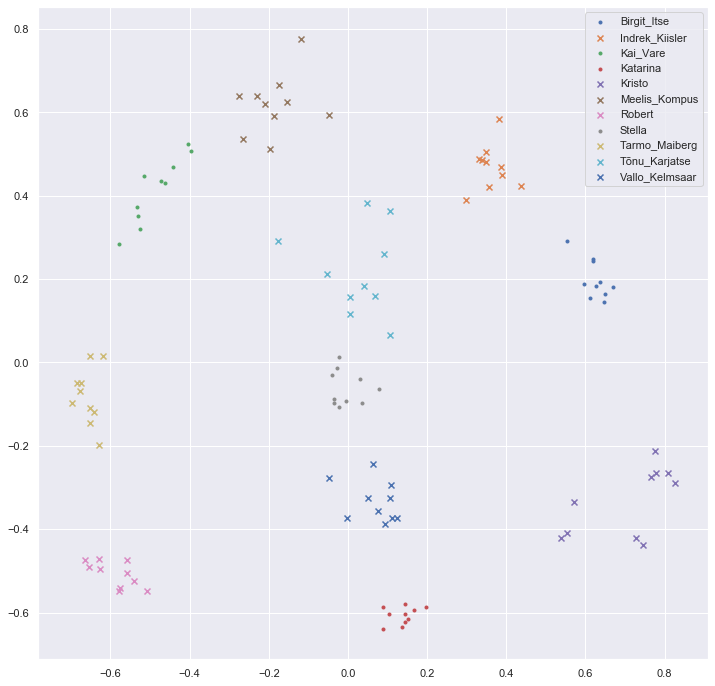

In [106]:
print('Konekorpus')
embeddings_konekorpus = get_embeddings(model_k, test_konekorpus_sample, konekorpus_dir)
embedding_stats(embeddings_konekorpus, 11, 10)
pca_plot(embeddings_konekorpus, test_konekorpus_sample['speaker'], konekorpus_speakers_genders)

Common Voice
Losses [101.3550796508789, 55.1349983215332, 29.005056381225586, 21.70238494873047] avg 69.07
Clusterness (+) 0.31
Contrast (-) 0.41
None


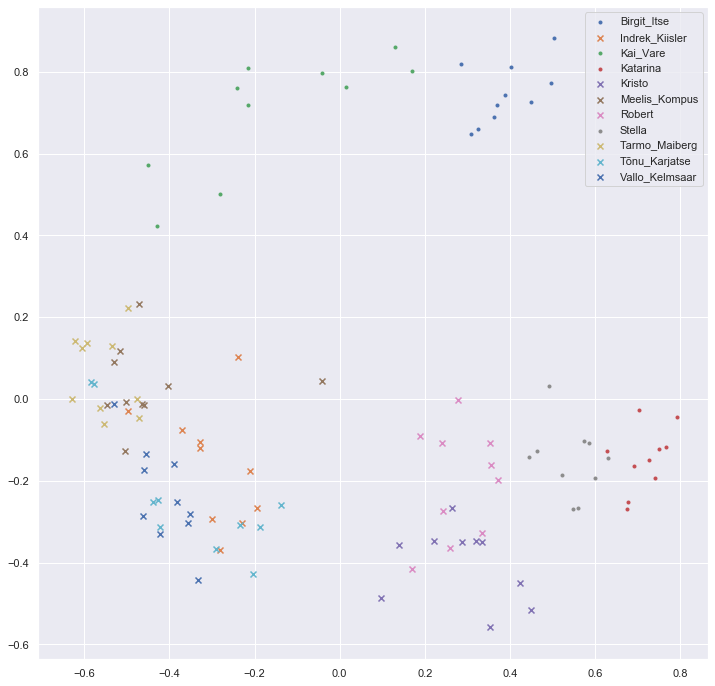

In [107]:
print('Common Voice')
embeddings_konekorpus = get_embeddings(model_c, test_konekorpus_sample, konekorpus_dir)
embedding_stats(embeddings_konekorpus, 11, 10)
pca_plot(embeddings_konekorpus, test_konekorpus_sample['speaker'], konekorpus_speakers_genders)

VCTK 1
Losses [110.32272338867188, 66.32345581054688, 46.80610275268555, 50.96134567260742] avg 91.47
Clusterness (+) 0.30
Contrast (-) 0.37
None


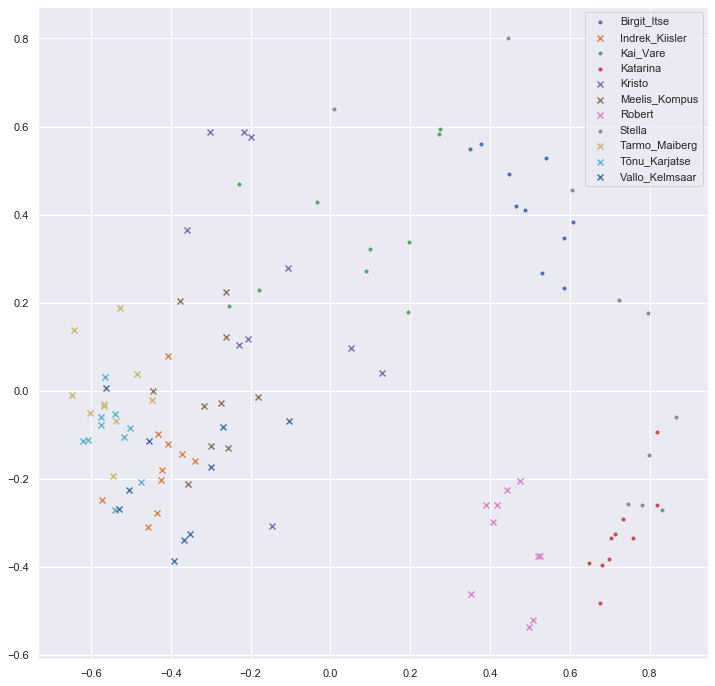

In [108]:
print('VCTK 1')
embeddings_konekorpus = get_embeddings(model_v, test_konekorpus_sample, konekorpus_dir)
embedding_stats(embeddings_konekorpus, 11, 10)
pca_plot(embeddings_konekorpus, test_konekorpus_sample['speaker'], konekorpus_speakers_genders)

VCTK 2
Losses [114.19776153564453, 68.65501403808594, 49.17466735839844, 54.96896743774414] avg 95.67
Clusterness (+) 0.30
Contrast (-) 0.40
None


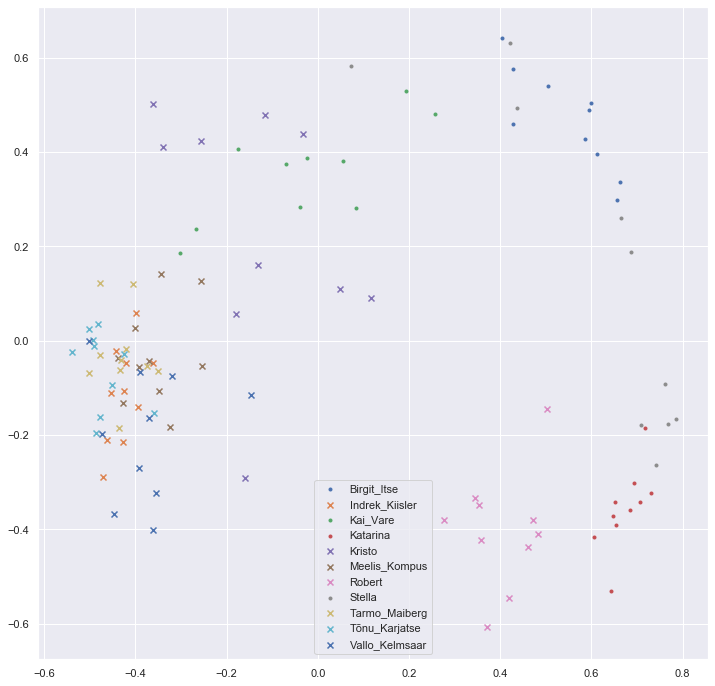

In [109]:
print('VCTK 2')
embeddings_konekorpus = get_embeddings(model_v2, test_konekorpus_sample, konekorpus_dir)
embedding_stats(embeddings_konekorpus, 11, 10)
pca_plot(embeddings_konekorpus, test_konekorpus_sample['speaker'], konekorpus_speakers_genders)

#### VCTK Test Data

Konekorpus
Losses [465.5299377441406, 337.4287414550781, 242.05300903320312, 209.31805419921875] avg 418.11
Clusterness (+) 0.15
Contrast (-) 0.52


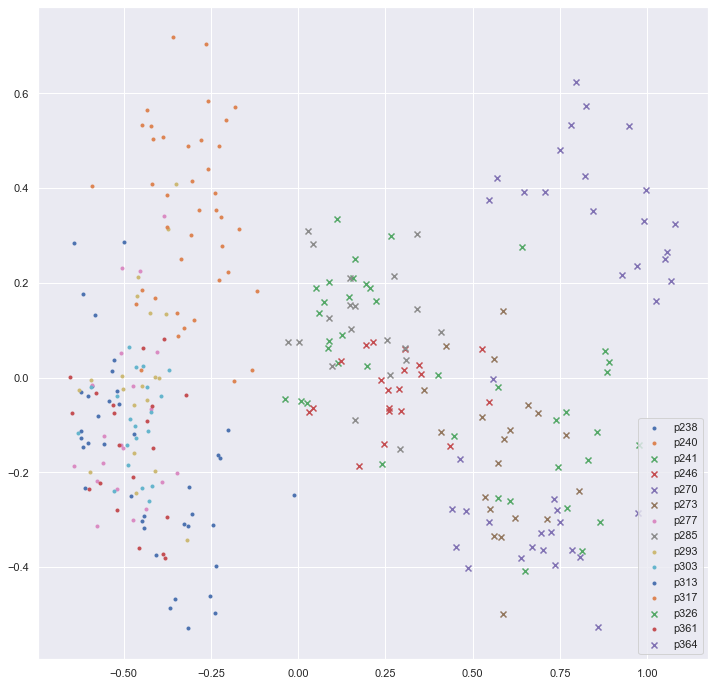

In [110]:
print('Konekorpus')
embeddings_vctk = get_embeddings(model_k, test_vctk_sample, vctk_dir)
embedding_stats(embeddings_vctk, 15, 20)
pca_plot(embeddings_vctk, test_vctk_sample['speaker'], vctk_speakers_genders)

Common Voice
Losses [601.3781127929688, 455.6705017089844, 285.449462890625, 151.81817626953125] avg 498.11
Clusterness (+) 0.16
Contrast (-) 0.80


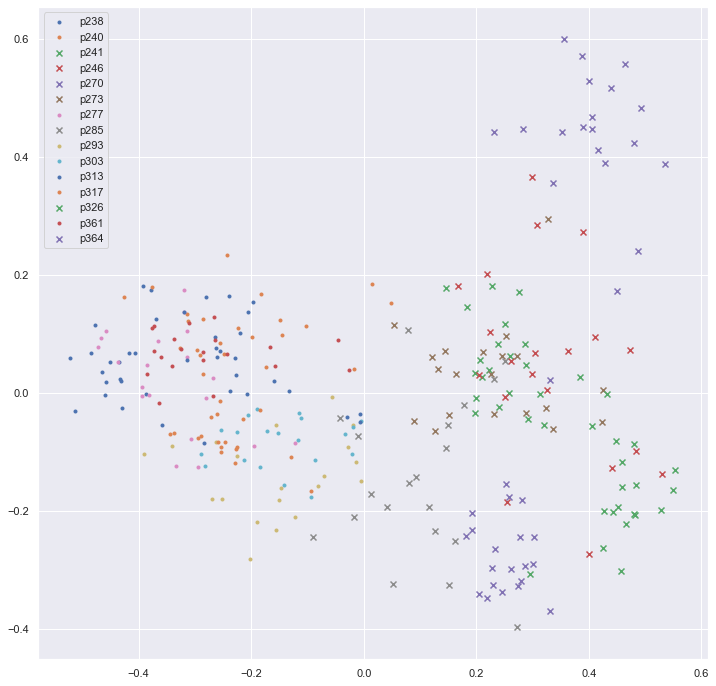

In [111]:
print('Common Voice')
embeddings_vctk = get_embeddings(model_c, test_vctk_sample, vctk_dir)
embedding_stats(embeddings_vctk, 15, 20)
pca_plot(embeddings_vctk, test_vctk_sample['speaker'], vctk_speakers_genders)

VCTK 1
Losses [79.0986557006836, 7.778340816497803, 0.7939977645874023, 0.08295249938964844] avg 29.25
Clusterness (+) 0.15
Contrast (-) 0.05


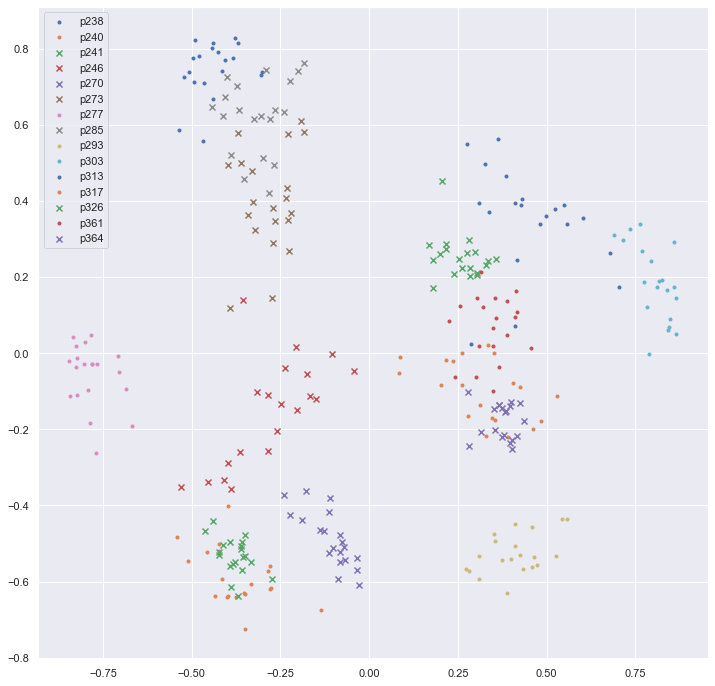

In [112]:
print('VCTK 1')
embeddings_vctk = get_embeddings(model_v, test_vctk_sample, vctk_dir)
embedding_stats(embeddings_vctk, 15, 20)
pca_plot(embeddings_vctk, test_vctk_sample['speaker'], vctk_speakers_genders)

VCTK 2
Losses [81.10711669921875, 6.3858113288879395, 0.21579933166503906, 0.0025005340576171875] avg 29.24
Clusterness (+) 0.15
Contrast (-) 0.10


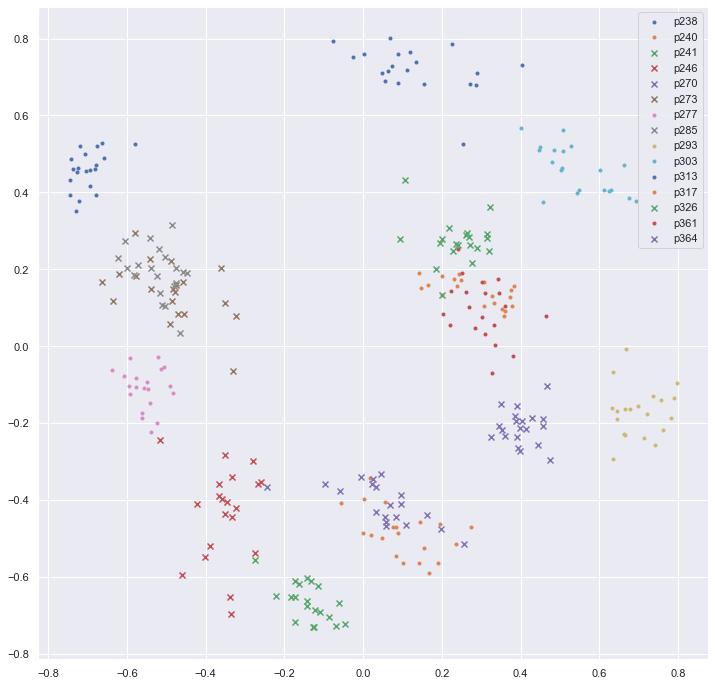

In [113]:
print('VCTK 2')
embeddings_vctk = get_embeddings(model_v2, test_vctk_sample, vctk_dir)
embedding_stats(embeddings_vctk, 15, 20)
pca_plot(embeddings_vctk, test_vctk_sample['speaker'], vctk_speakers_genders)